# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: MAX + MAX_BONUS

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium
!pip install optuna


[notice] A new release of pip is available: 24.1.1 -> 24.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.1 -> 24.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [3]:
import math 

import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as sps

from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

np.random.seed(43)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
df = pd.read_csv("./nyc-taxi-trip-duration/train.csv")

In [5]:
df.isnull().any().any()

False

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df = df.drop('dropoff_datetime', axis=1)

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

**Замечание:** так мы ничего не увидим из-за выбросов, так что для начала давайте откинем их (пока только для отрисовки так как ниже еще ассерты нужно проходить). Аномально маленький `trip_duration` я не считаю выбросами (не хочу объяснять логику если этого не просят в задании).

In [7]:
qmax = df['trip_duration'].max()

q999 = df['trip_duration'].quantile(0.999)
q998 = df['trip_duration'].quantile(0.998)
q997 = df['trip_duration'].quantile(0.997)

print(q997, q998, q999, qmax)

4764.070999999996 5551.71399999992 85128.35700000008 3526282


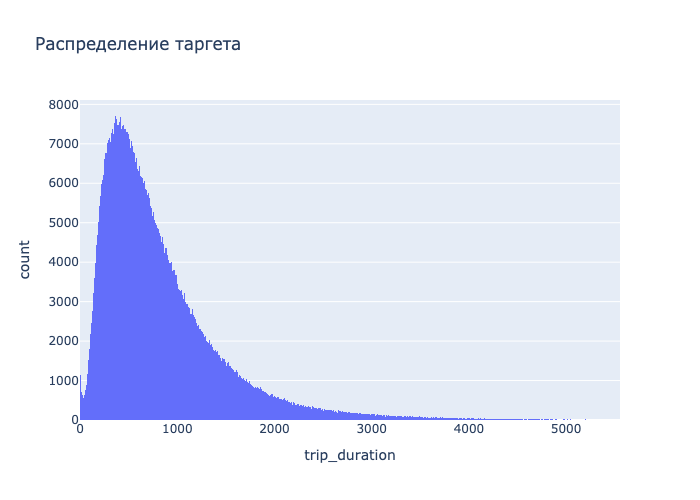

In [8]:
fig = px.histogram(df[df['trip_duration'] < q998], x='trip_duration', title='Распределение таргета')

fig.show(renderer='png')

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ:** Мы наблюдаем лог-нормальное распределение с аномалией слева (поездки меньше пяти секунд, из них возможно получится извлечь какую-то полезную информацию) и справа (поездки больше двух часов - случайные ошибки).

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ:** Из-за распределения таргета (после логарифмирования оно будет нормальным) и того, что при использовании RMSE выбросы очень сильно испортили бы функционал потерь.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: Очевидно, нет?

$$\text{RMSE}(X, \hat{y}, \hat{a}) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i  - \hat{a}(x_i)\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \text{RMSLE}(X, y, a)$$

Функции потель одинаковы, а значит оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$. 

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

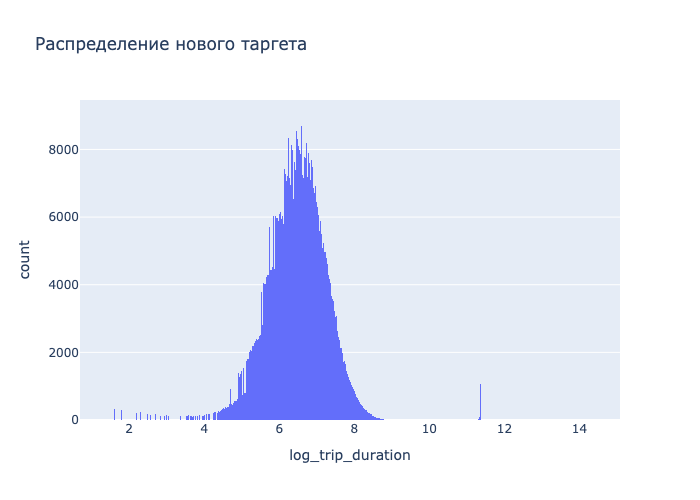

In [9]:
df['log_trip_duration'] = df['trip_duration'].apply(np.log1p)
df.drop('trip_duration', axis=1, inplace=True)

fig = px.histogram(df, x='log_trip_duration', title='Распределение нового таргета')

fig.show(renderer='png')

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [10]:
TARGET = 'log_trip_duration'

N = df[TARGET].shape[0]
BEST_CONST = df[TARGET].mean() * np.ones(N)

def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(mean_squared_error(log1p_y_true, log1p_y_pred))

rmsle_best_const = rmsle(df[TARGET], BEST_CONST)
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

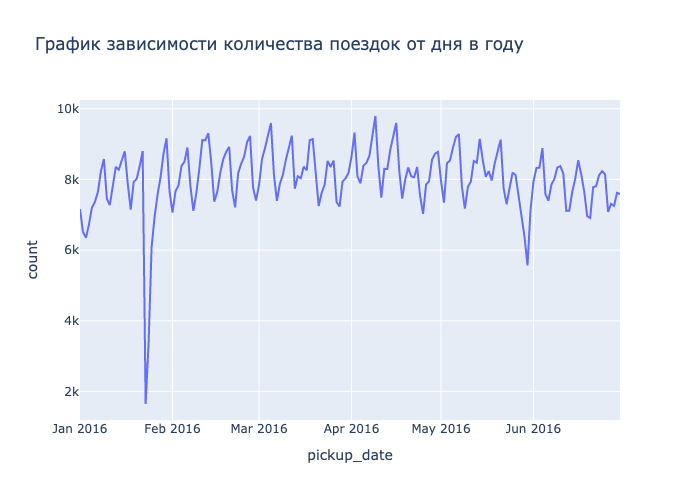

In [11]:
df['pickup_date'] = df['pickup_datetime'].dt.date

trips_by_pickup_date = df['pickup_date'].value_counts().sort_index().reset_index().rename(columns={'pickup_datetime' : 'pickup_date'})

fig = px.line(
    trips_by_pickup_date,
    x='pickup_date',
    y='count',
    title='График зависимости количества поездок от дня в году'
)

fig.show(renderer='png')

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

**Ответ:** Смотрим на интерактивный график плотли и видим пик Jan 22 - Jan 30 May 25 - Jun 2
* January 2016 United States blizzard. A travel ban was instituted for New York City and Newark, New Jersey, for January 23–24

* May 30 Memorial Day parade

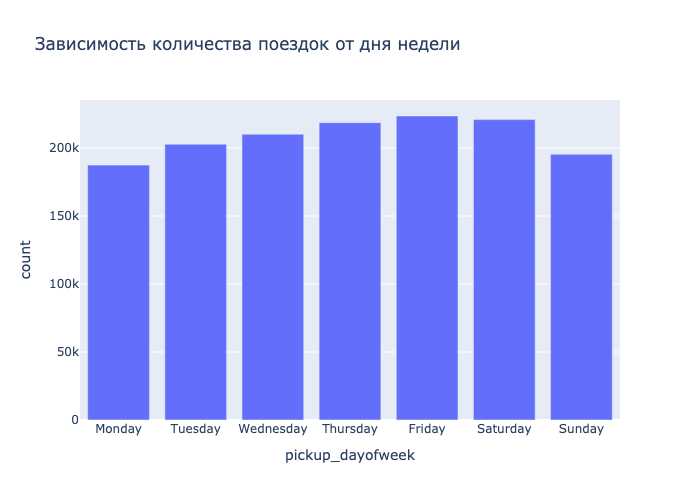

In [12]:
df['pickup_dayofweek'] = df['pickup_datetime'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

trips_by_pickup_dayofweek = df['pickup_dayofweek'].value_counts().reindex(ordered_days).reset_index()

fig = px.bar(
    trips_by_pickup_dayofweek,
    x='pickup_dayofweek',
    y='count',
    title='Зависимость количества поездок от дня недели'
)

fig.show(renderer='png')

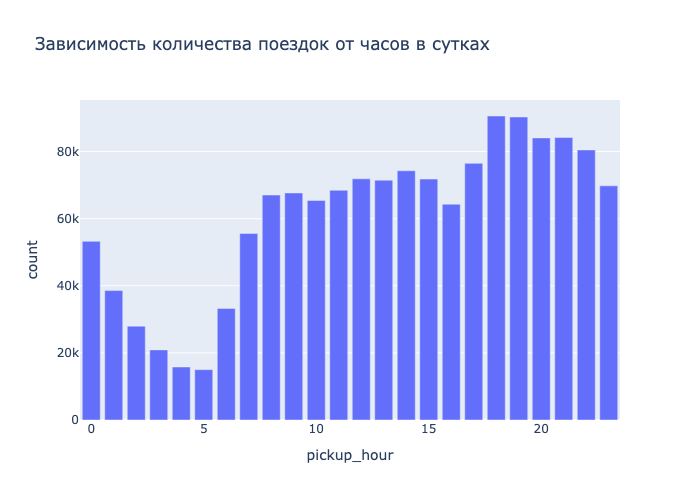

In [13]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour

trips_by_pickup_hour = df['pickup_hour'].value_counts().sort_index().reset_index()

fig = px.bar(
    trips_by_pickup_hour,
    x='pickup_hour',
    y='count',
    title='Зависимость количества поездок от часов в сутках'
)

fig.show(renderer='png')

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

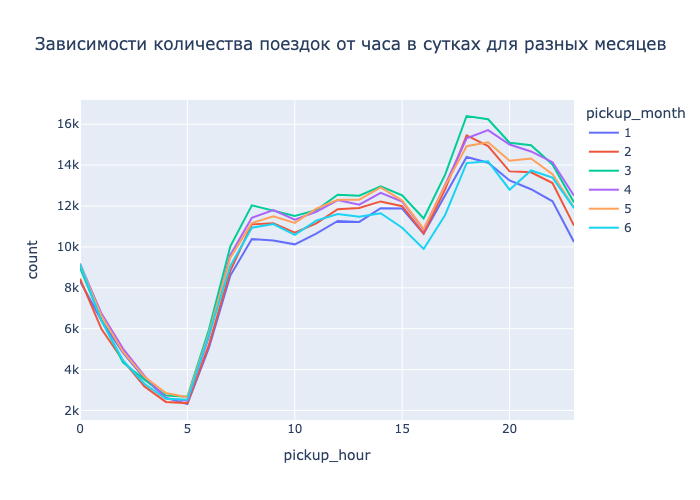

In [14]:
df['pickup_month'] = df['pickup_datetime'].dt.month

fig = px.line(
    df.groupby(['pickup_hour', 'pickup_month']).size().reset_index(name='count'),
    x='pickup_hour',
    y='count',
    color='pickup_month',
    title='Зависимости количества поездок от часа в сутках для разных месяцев'
)

fig.show(renderer='png')

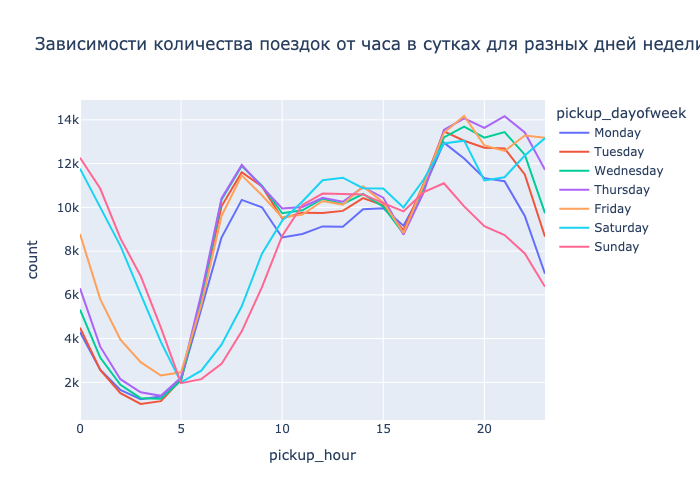

In [15]:
fig = px.line(
    df.groupby(['pickup_hour', 'pickup_dayofweek']).size().reset_index(name='count'),
    x='pickup_hour',
    y='count',
    color='pickup_dayofweek',
    category_orders={'pickup_dayofweek': ordered_days},
    title='Зависимости количества поездок от часа в сутках для разных дней недели'
)

fig.show(renderer='png')

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ:** Статзначимой зависимости от месяцев нет. Из дней выделяются выходные, да и между вечерами выходных тоже видны различия. От времени суток зависимости тоже есть. Объяснять что у людей есть работа и она начинается и заканчивается в определенное время в определенные дни я считаю излишним.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [16]:
df_train, df_test= train_test_split(df, test_size=0.3)

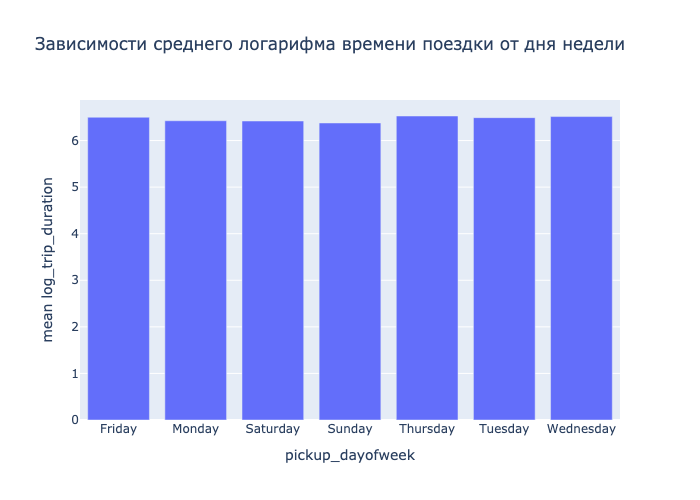

In [17]:
fig = px.bar(
    df_train.groupby(['pickup_dayofweek'])['log_trip_duration'].mean().reset_index(name='mean log_trip_duration'),
    x='pickup_dayofweek',
    y='mean log_trip_duration',
    title='Зависимости среднего логарифма времени поездки от дня недели'
)

fig.show(renderer='png')

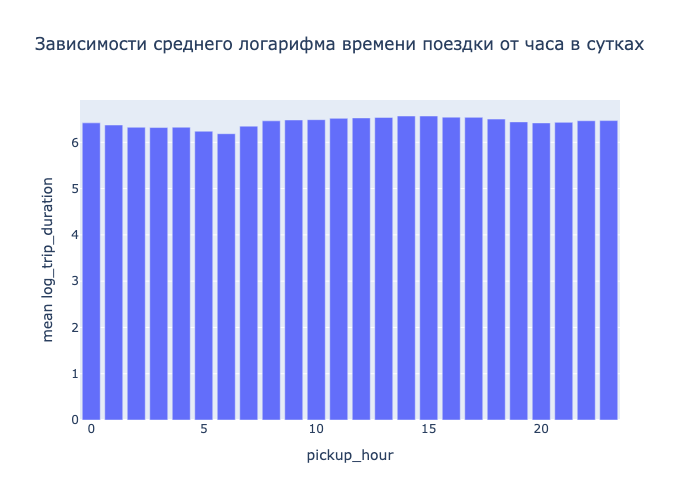

In [18]:
fig = px.bar(
    df_train.groupby(['pickup_hour'])['log_trip_duration'].mean().reset_index(name='mean log_trip_duration'),
    x='pickup_hour',
    y='mean log_trip_duration',
    title='Зависимости среднего логарифма времени поездки от часа в сутках'
)

fig.show(renderer='png')

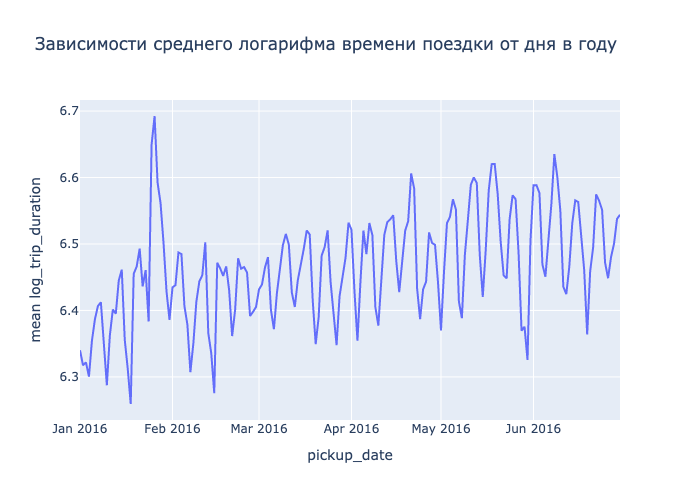

In [19]:
fig = px.line(
    df_train.groupby(['pickup_date'])['log_trip_duration'].mean().reset_index(name='mean log_trip_duration'),
    x='pickup_date',
    y='mean log_trip_duration',
    title='Зависимости среднего логарифма времени поездки от дня в году'
)

fig.show(renderer='png')

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ:** нет, так как среднее расстояние, а соответственно продолжительность поездки, и не должны зависеть от времени и дня недели. 

Во время бури продожительность поездок увеличилась (те, кто все-таки выходили из дома хотели доехать максимально близко до точки назначения, некоторе могли уезжать из города), а во время Memorial Day немного уменьшилась (наверное были сильные пробки и приходилось часть пути идти пешком).

Виден небольшой положительный тренд на графике зависимости `log_trip_duration` от номера дня в году.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [20]:
# уже все добавил кроме флага аномальности и номера дня в году

def add_some_cols(df):
    df['anomaly_flg'] = np.where(
        ((df['pickup_datetime'] >= '2016-01-22') & (df['pickup_datetime'] <= '2016-01-30')) |
        ((df['pickup_datetime'] >= '2016-05-25') & (df['pickup_datetime'] <= '2016-06-02')),
        1,
        0
    )
    
    df['pickup_dayofyear'] = df['pickup_datetime'].dt.dayofyear

    
add_some_cols(df_test)
add_some_cols(df_train)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Ответ:** Категориальными являются `pickup_dayofweek`, `pickup_month`, `anomaly_flg`, `pickup_hour`. В целом понятно - у них нет явно линейной зависимости с таргетом и про них мы больше рассуждаем как "было ли воскресенье", чем "был ли на один день больше". Из признаков что мы пока еще не рассматривали к категориальным можно еще отнести `vendor_id`,  и `store_and_fwd_flag`.

Следовательно остальные признаки численные.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [21]:
TARGET = 'log_trip_duration'

NUMERIC_FEATS = ['pickup_dayofyear']
CATEGORICAL_FEATS = ['pickup_dayofweek', 'pickup_month', 'anomaly_flg', 'pickup_hour']

column_transformer = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), NUMERIC_FEATS),  
        ('ohe', OneHotEncoder(drop='first'), CATEGORICAL_FEATS)
    ]
)

model = Pipeline(
    steps = [
        ('transformer', column_transformer),
        ('regression', Ridge())
    ]
)

model.fit(df_train[NUMERIC_FEATS + CATEGORICAL_FEATS], df_train[TARGET])

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['pickup_dayofyear']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['pickup_dayofweek',
                                                   'pickup_month',
                                                   'anomaly_flg',
                                                   'pickup_hour'])])),
                ('regression', Ridge())])

In [22]:
predict = model.predict(df_test[NUMERIC_FEATS + CATEGORICAL_FEATS])

rmsle(df_test[TARGET], predict)

0.7885606112213068

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [23]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
    radius: int = 100
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=radius,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишите функцию, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [24]:
df_sample = df.sample(3000)

your_lat_values = df_sample['pickup_latitude']
your_lon_values = df_sample['pickup_longitude']

show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Ответ:** Два аэропорта и возможно сам Манхэттен. В этих точках особая структура трафика, что может быть полезно

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [25]:
# кстати, а зачем нам это если на масштабах города там в пару метров разница будет 

# код с семинара lets goooooo

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

df_train.loc[:, 'haversine_distance'] = haversine_array(
    df_train['pickup_latitude'].values,
    df_train['pickup_longitude'].values,
    df_train['dropoff_latitude'].values,
    df_train['dropoff_longitude'].values
)

df_test.loc[:, 'haversine_distance'] = haversine_array(
    df_test['pickup_latitude'].values,
    df_test['pickup_longitude'].values,
    df_test['dropoff_latitude'].values,
    df_test['dropoff_longitude'].values
)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм haversine в отдельную колонку log_haversine:

In [26]:
df_train['log_haversine'] = df_train['haversine_distance'].apply(np.log1p)
df_test['log_haversine'] = df_test['haversine_distance'].apply(np.log1p)

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [27]:
df_train[
    [
        'haversine_distance',
        'log_haversine',
        TARGET
    ]
].corr()

,haversine_distance,log_haversine,log_trip_duration
haversine_distance,1.000000,0.858034,0.582926
log_haversine,0.858034,1.000000,0.750007
log_trip_duration,0.582926,0.750007,1.000000


Ну да, с логарифмом больше.

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [28]:
df_train['avg speed (km/h)'] = np.expm1(df_train['log_haversine']) / (np.expm1(df_train['log_trip_duration']) / 60**2)

q_speed_999 = df_train['avg speed (km/h)'].quantile(0.999)

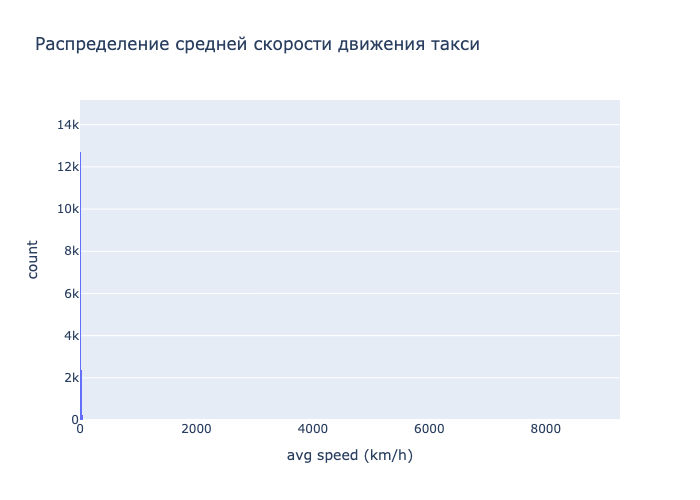

In [29]:
fig = px.histogram(
    df_train,
    x = 'avg speed (km/h)',
    title='Распределение средней скорости движения такси'
)

fig.show(renderer='png')

# очевидно что нужно клипать, но это ниже просят так что наверное не нужно


Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

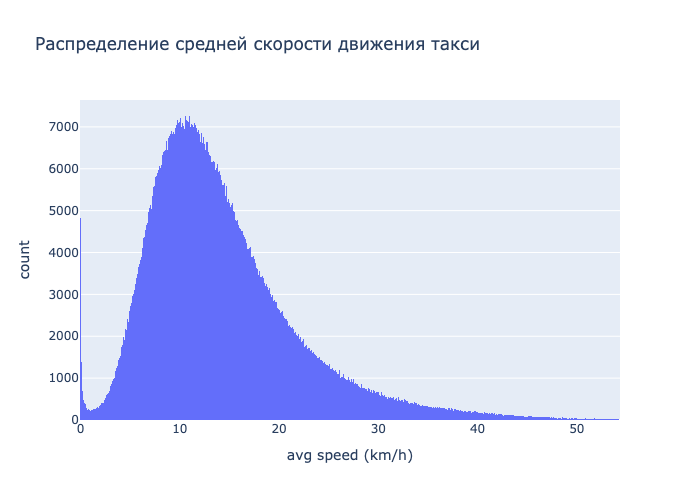

In [30]:
fig = px.histogram(
    df_train[df_train['avg speed (km/h)'] < q_speed_999],
    x = 'avg speed (km/h)',
    title='Распределение средней скорости движения такси'
)

fig.show(renderer='png')

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

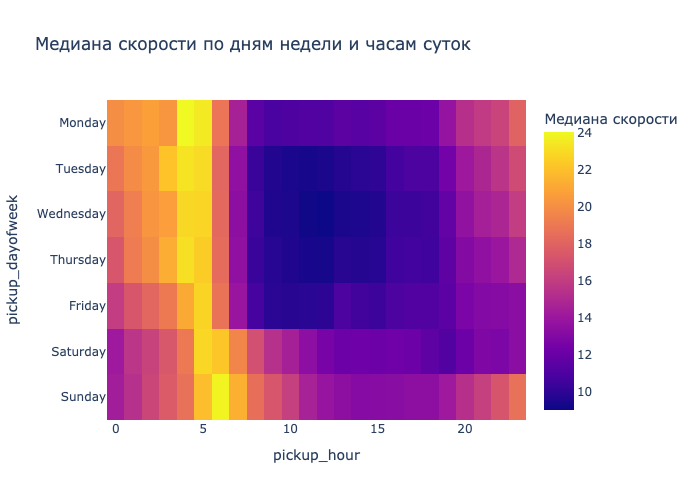

In [31]:
median_speed_df = df_train.groupby(['pickup_dayofweek', 'pickup_hour'])['avg speed (km/h)'].median().reset_index()

median_speed_df['median avg speed (km/h)'] = median_speed_df['avg speed (km/h)']

median_speed_df['pickup_dayofweek'] = pd.Categorical(median_speed_df['pickup_dayofweek'], categories=ordered_days, ordered=True)

heatmap_df = median_speed_df.pivot(index='pickup_dayofweek', columns='pickup_hour', values='median avg speed (km/h)')

fig = px.imshow(
    heatmap_df,
    x=heatmap_df.columns,
    y=heatmap_df.index,
    labels=dict(color='Медиана скорости'),
    title='Медиана скорости по дням недели и часам суток'
)

fig.show(renderer='png')

In [32]:
df_train.drop(columns=['avg speed (km/h)'], inplace=True)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ:** Ну мы в таргет смотрим, так нельзя (этой информации у нас на тесте не должно быть).

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

**Ответ:** Максимум по будням в часы пик, а минимум рано утром, и особенно рано утром в выходняе (удивительно, не правда ли?).

*Как же надоело базу писать в ответах я не могу*

In [33]:
# я сразу сделаю один нормальный числовой признак 'плохости' дорог

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

def road_condition(row):
    if row['pickup_dayofweek'] in weekdays:
        if row['pickup_hour'] >= 4 and row['pickup_hour'] <= 5:
            return 1
        
        if row['pickup_hour'] >= 7 and row['pickup_hour'] <= 23:
            return 3
            
        return 2
    
    else:
        if row['pickup_hour'] >= 5 and row['pickup_hour'] <= 6:
            return 1
        
        if row['pickup_hour'] >= 11 and row['pickup_hour'] <= 21:
            return 3
            
        return 2

df_train['road_condition'] = df_train.apply(road_condition, axis=1)
df_test['road_condition'] = df_test.apply(road_condition, axis=1)

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

**Ответ:** Два аэропорта. В этих точках особая структура трафика, что может быть полезно

In [34]:
def add_pickup_flag(df, name, target_lat, target_lon, radius):
    df[name] = haversine_array(df['pickup_latitude'].to_numpy(), df['pickup_longitude'].to_numpy(), target_lat, target_lon) < radius
    return df


def add_dropoff_flag(df, name, target_lat, target_lon, radius):
    df[name] = haversine_array(df['dropoff_latitude'].to_numpy(), df['dropoff_longitude'].to_numpy(), target_lat, target_lon) < radius
    return df

df_show = df_train.sample(10000)

In [35]:
df_show = add_pickup_flag(df_show, 'p_jfk', 40.65, -73.79, 2)
df_show = add_dropoff_flag(df_show, 'd_jfk', 40.65, -73.79, 2)

# show_circles_on_map(
#     df_show[df_show['p_jfk'] == 1]['pickup_latitude'],
#     df_show[df_show['p_jfk'] == 1]['pickup_longitude']
# )

In [36]:
df_show = add_pickup_flag(df_show, 'p_laguarda', 40.774, -73.871, 1.2)
df_show = add_dropoff_flag(df_show, 'd_laguarda', 40.774, -73.871, 1.2)

# show_circles_on_map(
#     df_show[df_show['p_laguarda'] == 1]['pickup_latitude'],
#     df_show[df_show['p_laguarda'] == 1]['pickup_longitude']
# )

In [37]:
# преобразуем все фичи

df_train = add_pickup_flag(df_train, 'p_jfk', 40.65, -73.79, 2)
df_train = add_dropoff_flag(df_train, 'd_jfk', 40.65, -73.79, 2)

df_train = add_pickup_flag(df_train, 'p_laguarda', 40.774, -73.871, 1.2)
df_train = add_dropoff_flag(df_train, 'd_laguarda', 40.774, -73.871, 1.2)

df_test = add_pickup_flag(df_test, 'p_jfk', 40.65, -73.79, 2)
df_test = add_dropoff_flag(df_test, 'd_jfk', 40.65, -73.79, 2)

df_test = add_pickup_flag(df_test, 'p_laguarda', 40.774, -73.871, 1.2)
df_test = add_dropoff_flag(df_test, 'd_laguarda', 40.774, -73.871, 1.2)


Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

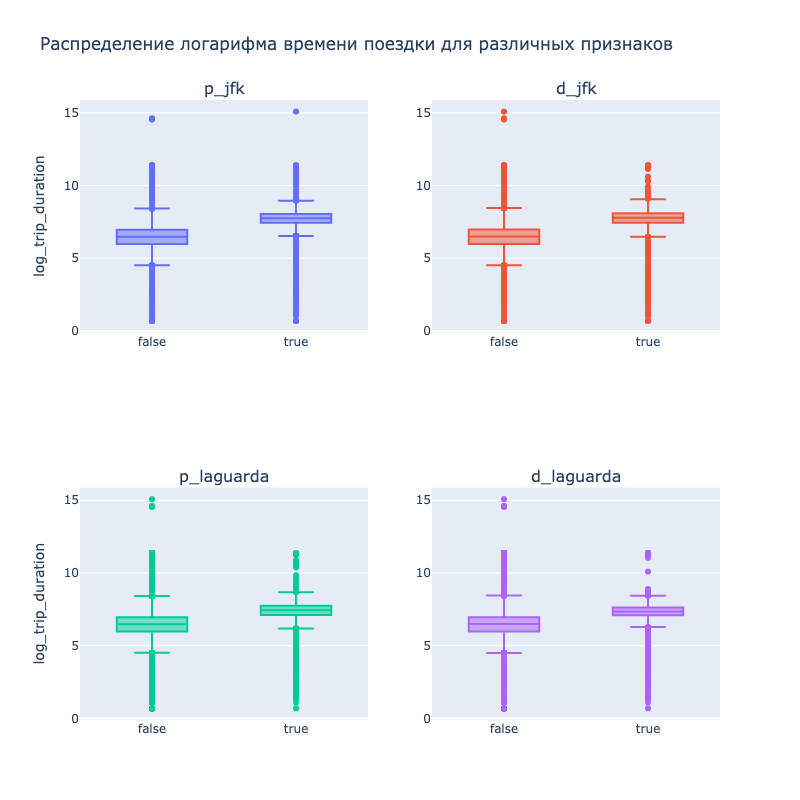

In [38]:
from plotly.subplots import make_subplots

features = ['p_jfk', 'd_jfk', 'p_laguarda', 'd_laguarda']

fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=features
)

for i, feature in enumerate(features):
    row = i // 2 + 1
    col = i % 2 + 1
    
    boxplot = go.Box(x=df_train[feature], y=df_train[TARGET], name=feature)
    fig.add_trace(boxplot, row=row, col=col)
    
    fig.update_yaxes(
        title_text=TARGET,
        row=row,
        col=1
    )

fig.update_layout(
    title="Распределение логарифма времени поездки для различных признаков",
    showlegend=False,
    height=800,
    width=800
)

fig.show(renderer='png')

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ:** Флаги аэропортов полезыные.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.display import display

class MapGridTransformer(BaseEstimator, TransformerMixin):
    
    out_features = ['pickup_cell', 'dropoff_cell']

    def __init__(self, n_rows=20, n_cols=20, quantile=0.99):
        
        self.quantile = quantile
                
        self.n_rows = n_rows
        self.n_cols = n_cols
        
        self.grid_x = None
        self.grid_y = None
        
    def show_map(self):        
        m = folium.Map(location=(np.mean(self.grid_y), np.mean(self.grid_x))) 
        
        # это писал гпт
        
        for x in self.grid_x:
            folium.PolyLine([(y, x) for y in self.grid_y], color="blue", weight=1).add_to(m)
        for y in self.grid_y:
            folium.PolyLine([(y, x) for x in self.grid_x], color="blue", weight=1).add_to(m)

        return m

    def fit(self, X=None, y=None):
        """
        
        X.columns = [
            'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'
        ]
            
        """
        
        X = X[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].to_numpy()
        
        hq = (1 - self.quantile) / 2

        min_long = np.quantile(X[:, [0, 2]], hq)
        max_long = np.quantile(X[:, [0, 2]], 1 - hq)
        
        min_lat = np.quantile(X[:, [1, 3]], hq)
        max_lat = np.quantile(X[:, [1, 3]], 1 - hq)
                        
        self.grid_x = np.linspace(min_long, max_long, self.n_cols + 1)
        self.grid_y = np.linspace(min_lat, max_lat, self.n_rows + 1)
                                          
        return self
        
    def _get_cell_index(self, longitude, latitude):
        
        # тоже гпт написал
            
        x_idx = np.digitize(longitude, self.grid_x) - 1
        y_idx = np.digitize(latitude, self.grid_y) - 1
                
        x_idx = np.clip(x_idx, 0, self.n_cols - 1)
        y_idx = np.clip(y_idx, 0, self.n_rows - 1)
        
        return y_idx * self.n_cols + x_idx
        
    def transform(self, X, y=None):        
        X = X.copy()
        
        X['pickup_cell'] = self._get_cell_index(X['pickup_longitude'], X['pickup_latitude'])
        X['dropoff_cell'] = self._get_cell_index(X['dropoff_longitude'], X['dropoff_latitude'])
                                
        return X

In [40]:
mgt = MapGridTransformer(15, 15).fit(df_train)
mgt.show_map()

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [41]:

def fit_predict(
    df_train, 
    df_test,
    NUMERIC_FEATS,
    CATEGORICAL_FEATS,
    regression=Ridge(),
    n_rows=20,
    n_cols=20,
    quantile=0.99, 
    callback=None
):
    
    NUMERIC_FEATS = NUMERIC_FEATS.copy()
    CATEGORICAL_FEATS = CATEGORICAL_FEATS.copy()

    # >>> манипуляции с картой
    
    mgt = MapGridTransformer(n_rows, n_cols, quantile).fit(df_train)
    
    df_train = mgt.transform(df_train) 
    df_test = mgt.transform(df_test)
    
    # <<< манипуляции с картой

    CATEGORICAL_FEATS += MapGridTransformer.out_features
    TARGET = 'log_trip_duration'
    
    column_transformer = ColumnTransformer(
        transformers = [
            ('num', StandardScaler(), NUMERIC_FEATS),  
            ('ohe', OneHotEncoder(drop='first', handle_unknown="ignore"), CATEGORICAL_FEATS),
        ]
    )

    model = Pipeline(
        steps = [
            ('transformer', column_transformer),
            ('regression', regression)
        ]
    )
    
    model.fit(df_train[NUMERIC_FEATS + CATEGORICAL_FEATS], df_train[TARGET])
    predict = model.predict(df_test[NUMERIC_FEATS + CATEGORICAL_FEATS])
        
    if callback is not None:
        return rmsle(df_test[TARGET], predict), callback(model)

    return rmsle(df_test[TARGET], predict)

In [42]:
NUMERIC_FEATS = [
    'pickup_dayofyear',
    'log_haversine'
]

CATEGORICAL_FEATS = [
    'pickup_dayofweek',
    'pickup_month',
    'anomaly_flg',
    'p_jfk',
    'd_jfk',
    'p_laguarda',
    'd_laguarda',
    'road_condition',
    'pickup_hour'
]

fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [9, 10] during transform. These unknown categories will be encoded as all zeros



0.4689702554738948

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

**Ответ:** vendor_id - некоторые такси могут работать только в определенных районах где средние скорости могут отличаться, passenger_count - редно больше одного человека ездит на работу в такси, поэтому тоже другое распределение мест назначения, store_and_fwd_flag - может служить индикатором чего-то необычного

In [43]:
df['vendor_id'].nunique()

2

In [44]:
df['passenger_count'].nunique()

10

In [45]:
df['store_and_fwd_flag'].nunique()

2

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

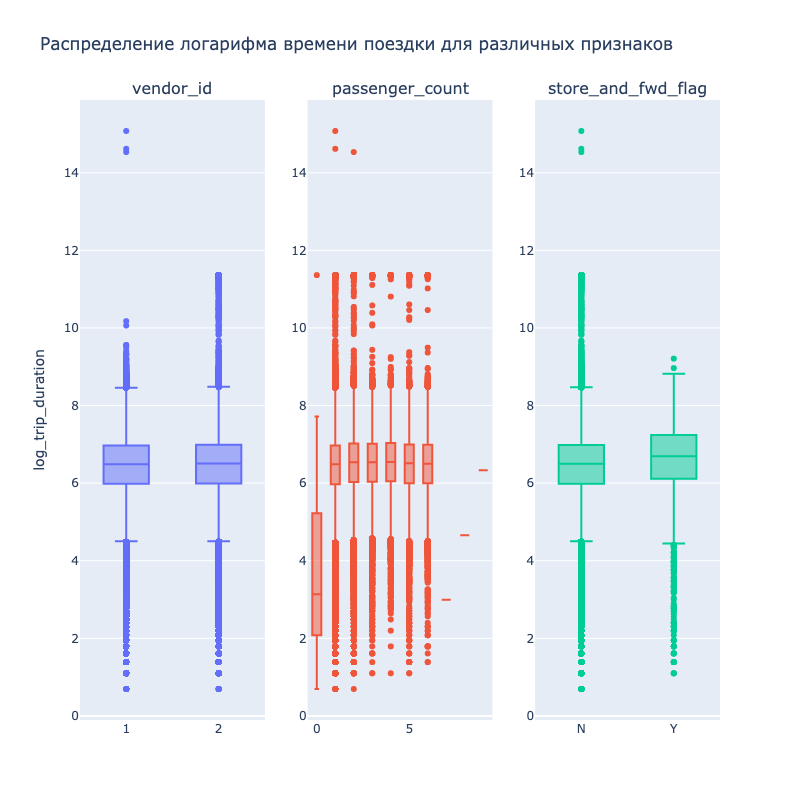

In [46]:
from plotly.subplots import make_subplots

features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=features
)

for i, feature in enumerate(features):    
    boxplot = go.Box(x=df_train[feature], y=df_train[TARGET], name=feature)
    fig.add_trace(boxplot, row=1, col=i + 1)
    
    fig.update_yaxes(
        title_text=TARGET,
        row=1,
        col=1
    )

fig.update_layout(
    title="Распределение логарифма времени поездки для различных признаков",
    showlegend=False,
    height=800,
    width=800
)

fig.show(renderer='png')

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [47]:
df_train['vendor_id'] = df_train['vendor_id'] - 1
df_test['vendor_id'] = df_test['vendor_id'] - 1

df_train['store_and_fwd_flag'] = np.where(df_train['store_and_fwd_flag'] == 'Y', 1, 0)
df_test['store_and_fwd_flag'] = np.where(df_test['store_and_fwd_flag'] == 'Y', 1, 0)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ:** Все кроме `vendor_id` - да

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [48]:
CATEGORICAL_FEATS = [
    'pickup_dayofweek',
    'pickup_month',
    'anomaly_flg',
    'p_jfk',
    'd_jfk',
    'p_laguarda',
    'd_laguarda',
    'road_condition',
    'pickup_hour',
    'vendor_id',
    'store_and_fwd_flag',
    'passenger_count',
]

fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [12, 13] during transform. These unknown categories will be encoded as all zeros



0.4684675710614914

In [49]:
CATEGORICAL_FEATS = [
    'pickup_dayofweek',
    'pickup_month',
    'anomaly_flg',
    'p_jfk',
    'd_jfk',
    'p_laguarda',
    'pickup_hour',
    'd_laguarda',
    'road_condition',
    'passenger_count',
]

fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [10, 11] during transform. These unknown categories will be encoded as all zeros



0.4685666782322869

Я был почти прав и `vendor_id` и `store_and_fwd_flag` не дают почти никакого прироста - добавим только `passenger_count`.

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

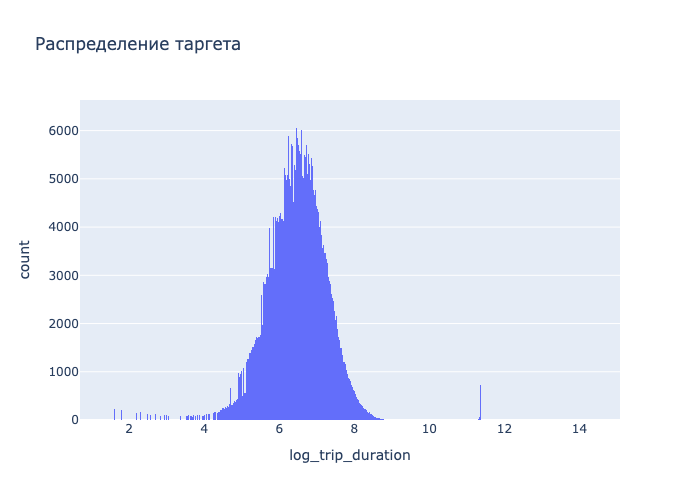

In [50]:
fig = px.histogram(df_train, x='log_trip_duration', title='Распределение таргета')

fig.show(renderer='png')

In [51]:
qmax = df_train['log_trip_duration'].max()

q9995 = df_train['log_trip_duration'].quantile(0.9995)
q999 = df_train['log_trip_duration'].quantile(0.999)

qmin = df_train['log_trip_duration'].min()

q0005 = df_train['log_trip_duration'].quantile(0.0005)
q001 = df_train['log_trip_duration'].quantile(0.001)

print(np.expm1(q999), np.expm1(q9995), np.expm1(qmax))
print(np.expm1(q001), np.expm1(q0005), np.expm1(qmin))

85111.90199890516 86090.47549855149 3526282.000000002
6.999999999999998 3.9999999999999996 1.0


In [52]:
df_train = df_train[df_train['log_trip_duration'] < q999]
df_train = df_train[df_train['log_trip_duration'] > q001]

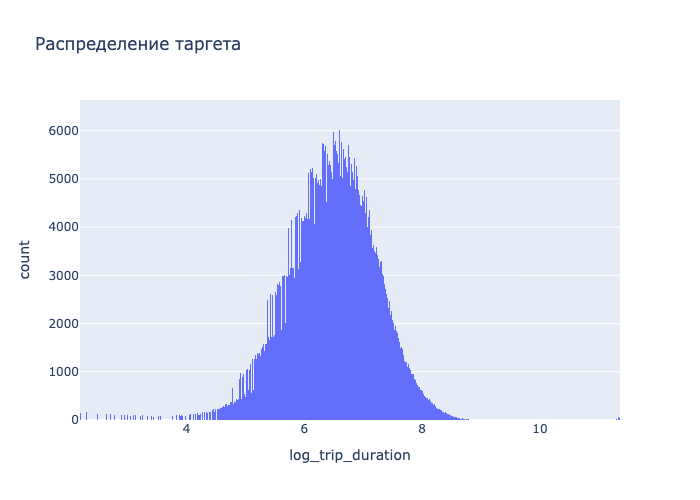

In [53]:
fig = px.histogram(df_train, x='log_trip_duration', title='Распределение таргета')

fig.show(renderer='png')

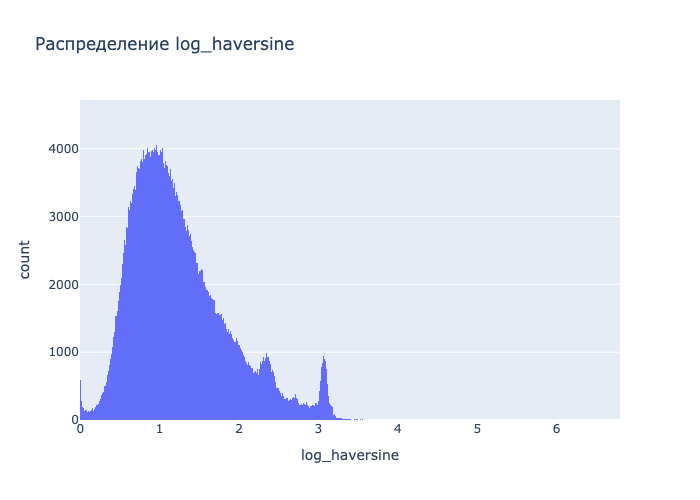

In [54]:
fig = px.histogram(df_train, x='log_haversine', title='Распределение log_haversine')

fig.show(renderer='png')

In [55]:
qmax = df_train['log_haversine'].max()

q9995 = df_train['log_haversine'].quantile(0.9995)
q999 = df_train['log_haversine'].quantile(0.999)

qmin = df_train['log_haversine'].min()

q002 = df_train['log_haversine'].quantile(0.02)
q001 = df_train['log_haversine'].quantile(0.01)

print(np.expm1(q999), np.expm1(q9995), np.expm1(qmax))
print(np.expm1(q002), np.expm1(q001), np.expm1(qmin))

24.731728865255086 28.2355323493337 891.2141032500347
0.3863504209668734 0.17734516616274498 0.0


In [56]:
df_train = df_train[df_train['log_haversine'] < q9995]
df_train = df_train[df_train['log_haversine'] > q001]

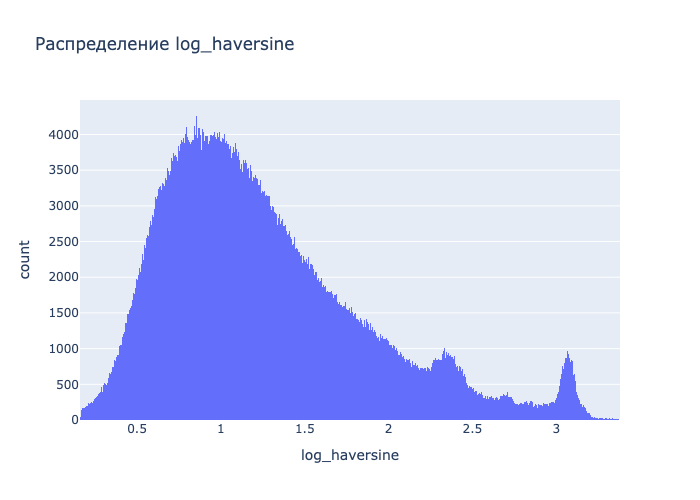

In [57]:
fig = px.histogram(df_train, x='log_haversine', title='Распределение log_haversine')

fig.show(renderer='png')

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [58]:

# мне потом понадобиться все это делать для различных признаков 
# так что добавим оъединение фичей с маленьким хитом в фитпредикт

def fit_predict(
    df_train, 
    df_test,
    NUMERIC_FEATS,
    CATEGORICAL_FEATS,
    regression=Ridge(),
    n_rows=20,
    n_cols=20,
    quantile=0.99, 
    feature_threshold = 100,
    callback=None
):
    
    NUMERIC_FEATS = NUMERIC_FEATS.copy()
    CATEGORICAL_FEATS = CATEGORICAL_FEATS.copy()

    # >>> манипуляции с картой
    
    mgt = MapGridTransformer(n_rows, n_cols, quantile).fit(df_train)
    
    df_train = mgt.transform(df_train) 
    df_test = mgt.transform(df_test)
    
    # <<< манипуляции с картой

    CATEGORICAL_FEATS += MapGridTransformer.out_features
    TARGET = 'log_trip_duration'
    
    # >>> объединяем категории 
    
    for feat in CATEGORICAL_FEATS:
        if df_train[feat].value_counts().min() < feature_threshold:

            freq = df_train[feat].value_counts()
            rare_categories = freq[freq < feature_threshold].index 

            df_train[feat] = df_train[feat].replace(rare_categories, -1)
            df_test[feat] = df_test[feat].replace(rare_categories, -1)
            
    # <<< объединяем категории 

    column_transformer = ColumnTransformer(
        transformers = [
            ('num', StandardScaler(), NUMERIC_FEATS),  
            ('ohe', OneHotEncoder(drop='first', handle_unknown="ignore"), CATEGORICAL_FEATS),
        ]
    )

    model = Pipeline(
        steps = [
            ('transformer', column_transformer),
            ('regression', regression)
        ]
    )
    
    model.fit(df_train[NUMERIC_FEATS + CATEGORICAL_FEATS], df_train[TARGET])
    predict = model.predict(df_test[NUMERIC_FEATS + CATEGORICAL_FEATS])
        
    if callback is not None:
        return rmsle(df_test[TARGET], predict), callback(model)

    return rmsle(df_test[TARGET], predict)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [59]:

NUMERIC_FEATS = [
    'pickup_dayofyear',
    'log_haversine'
]

CATEGORICAL_FEATS = [
    'pickup_dayofweek',
    'pickup_month',
    'anomaly_flg',
    'p_jfk',
    'd_jfk',
    'pickup_hour',
    'p_laguarda',
    'd_laguarda',
    'road_condition',
    'passenger_count',
]

fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [9, 10, 11] during transform. These unknown categories will be encoded as all zeros



0.4696482893944744

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [60]:
def callback(model):
    return model.named_steps['regression'].coef_

rmse, coef = fit_predict(
    df_train, 
    df_test,
    NUMERIC_FEATS,
    CATEGORICAL_FEATS,
    callback=callback
)

print("было:", len(NUMERIC_FEATS + CATEGORICAL_FEATS) + 2) # внутри fit_predict добавляются еще две
print("стало:", len(coef))

было: 14
стало: 385


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [9, 10, 11] during transform. These unknown categories will be encoded as all zeros



Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [61]:
fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge())

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [9, 10, 11] during transform. These unknown categories will be encoded as all zeros



0.4696482893944744

In [62]:
fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS, Lasso())

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [9, 10, 11] during transform. These unknown categories will be encoded as all zeros



0.7955034610948161

**Ответ:** `Ridge` лучше.

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [63]:
df_train, df_val = train_test_split(df_train, test_size=0.2)

In [64]:
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore', category=UserWarning)


log_space_values = np.logspace(-4, 1, 20)

ridge_vals = []
lasso_vals = []

for alpha in tqdm(log_space_values):
    lasso_vals.append(fit_predict(df_train, df_val, NUMERIC_FEATS, CATEGORICAL_FEATS, Lasso(alpha=alpha)))
    ridge_vals.append(fit_predict(df_train, df_val, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge(alpha=alpha)))

100%|████████████████████████████████████████████████████████████████████████████| 20/20 [04:59<00:00, 15.00s/it]


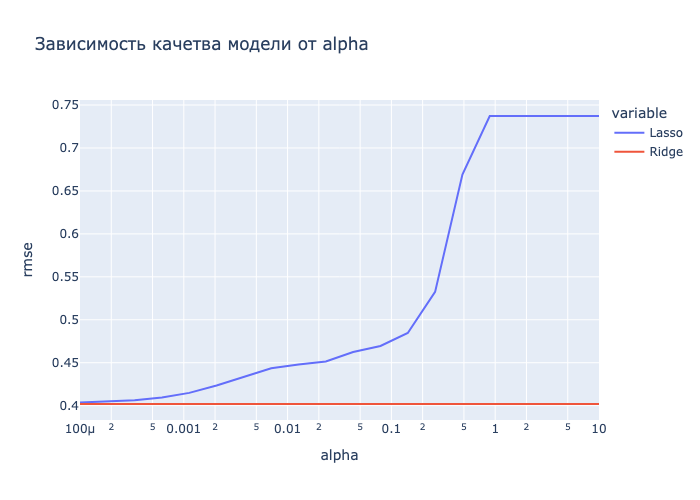

In [65]:
results_df = pd.DataFrame({
    'alpha': log_space_values,
    'Lasso': lasso_vals,
    'Ridge': ridge_vals
})

fig = px.line(results_df, x='alpha', y=['Lasso', 'Ridge'], 
              labels={'value': 'rmse', 'alpha': 'alpha'},
              title='Зависимость качетва модели от alpha',
              log_x=True)
              
fig.show(renderer='png')

Как мы видим rmse улучшается при уменьшении $alpha$, и оба классификатора сходятся - регуляризация с нашим размером выборки практически не нужна.

Сохраните наилучшее значение, как бенчмарк на будущее

In [66]:
best_rmse_val = min(ridge_vals)
best_alpha = log_space_values[np.argmin(ridge_vals)]

print(best_rmse_val, best_alpha)

0.4019539079352003 2.9763514416313193


In [67]:
best_rmse = fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge(alpha=best_alpha))

best_rmse

0.46993908619836783

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [68]:
def callback(model):
    return np.sum(model.named_steps['regression'].coef_ == 0)

num_of_zero_weights = []

for alpha in tqdm(log_space_values):
    _, w = fit_predict(df_train, df_val, NUMERIC_FEATS, CATEGORICAL_FEATS, Lasso(alpha=alpha), callback=callback)
    
    num_of_zero_weights.append(w)

100%|████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.93s/it]


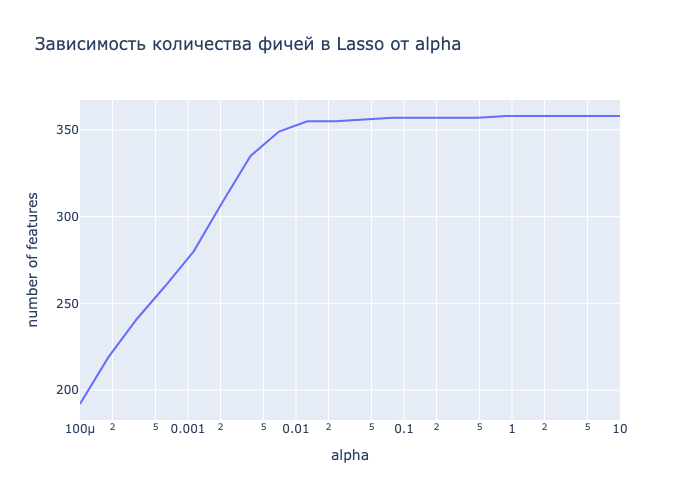

In [69]:
results_df = pd.DataFrame({
    'alpha': log_space_values,
    'number of features': num_of_zero_weights
})

fig = px.line(results_df, x='alpha', y='number of features', 
              title='Зависимость количества фичей в Lasso от alpha',
              log_x=True)
              
fig.show(renderer='png')

**Ответ:** Как видно из двух графиков выше даже если мы занулим 3/4 признаков качество модели практически не ухудшится.

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ:** Зависимости могут быть нелинейными. Две фичи могут быть поотдельности слабыми, но сильными вместе.

In [70]:
def fit_predict(
    df_train_, 
    df_test_,
    NUMERIC_FEATS,
    CATEGORICAL_FEATS,
    regression=Ridge(),
    n_rows=20,
    n_cols=20,
    quantile=0.99, 
    feature_threshold = 100,
    nlargest_routs = 100,
    callback=None
):
    
    NUMERIC_FEATS = NUMERIC_FEATS.copy()
    CATEGORICAL_FEATS = CATEGORICAL_FEATS.copy()

    # >>> манипуляции с картой
    
    mgt = MapGridTransformer(n_rows, n_cols, quantile).fit(df_train_)
    
    df_train_ = mgt.transform(df_train_) 
    df_test_ = mgt.transform(df_test_)
    
    CATEGORICAL_FEATS += MapGridTransformer.out_features
    
    # <<< манипуляции с картой

    TARGET = 'log_trip_duration'
    
    # >>> самые частые маршруты
    
    largest_routs = df_train_.groupby(['pickup_cell', 'dropoff_cell']).size().reset_index(name='count').nlargest(nlargest_routs, 'count')
    pair_dict = {f"{row['pickup_cell']}_{row['dropoff_cell']}": i for i, row in largest_routs.iterrows()}

    def encode_trip(row):
        key = f"{row['pickup_cell']}_{row['dropoff_cell']}"
        return pair_dict.get(key, -1)

    df_train_['encoded_trip'] = df_train_.apply(encode_trip, axis=1)
    df_test_['encoded_trip'] = df_test_.apply(encode_trip, axis=1)
    
    CATEGORICAL_FEATS += ['encoded_trip']
    
    # <<< самые частые маршруты

    # >>> объединяем категории 
    
    for feat in CATEGORICAL_FEATS:
        if df_train_[feat].value_counts().min() < feature_threshold:

            freq = df_train_[feat].value_counts()
            rare_categories = freq[freq < feature_threshold].index 

            df_train_[feat] = df_train_[feat].replace(rare_categories, -1)
            df_test_[feat] = df_test_[feat].replace(rare_categories, -1)
            
    # <<< объединяем категории 

    column_transformer = ColumnTransformer(
        transformers = [
            ('num', StandardScaler(), NUMERIC_FEATS),  
            ('ohe', OneHotEncoder(drop='first', handle_unknown="ignore"), CATEGORICAL_FEATS),
        ]
    )

    model = Pipeline(
        steps = [
            ('transformer', column_transformer),
            ('regression', regression)
        ]
    )
    
    model.fit(df_train_[NUMERIC_FEATS + CATEGORICAL_FEATS], df_train_[TARGET])
    predict = model.predict(df_test_[NUMERIC_FEATS + CATEGORICAL_FEATS])
        
    if callback is not None:
        return rmsle(df_test_[TARGET], predict), callback(model)

    return rmsle(df_test_[TARGET], predict)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [71]:
best_rmse_2 = fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge(alpha=best_alpha))

best_rmse_2

0.4649336548229407

In [72]:
best_rmse

0.46993908619836783

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

**Ответ:** Очев что такси не летают а двигаются по сетке улиц. Будем считать манхэттенское расстояние предварительно повернув сисетму координат (новые оси $x, y$ обозначены красным) так, чтобы улицы шли строго с севера на юг.

In [73]:
# напишем манхэттенское растояние с учетом угла наклона сетки улиц

import math 

def rotate_point_leftwise(y, x, angle):
    angle = math.radians(angle)
    
    x_rotated = x * np.cos(angle) - y * np.sin(angle)
    y_rotated = x * np.sin(angle) + y * np.cos(angle)
    
    return y_rotated, x_rotated

def skewed_manhattan_distance(lat1, lng1, lat2, lng2, angle):
    lat1, lng1  = rotate_point_leftwise(lat1, lng1, angle)
    lat2, lng2 = rotate_point_leftwise(lat2, lng2, angle)
    
    return haversine_array(lat1, lng1, lat1, lng2) + haversine_array(lat1, lng1, lat2, lng1)

In [74]:
location = (40.7185, -74)
m = folium.Map(location=location, zoom_start=14)  
    
offset = np.array([40.7185, -74])

x_axis = np.array([np.array([0, 0]), np.array([0.1, 0])])
y_axis = np.array([np.array([0, 0]), np.array([0, 0.1])])

for line in [x_axis + offset, y_axis + offset]:
    folium.PolyLine(
        locations=line,
        color='blue',
        weight=5,
        opacity=0.6
    ).add_to(m)
    
angle = 36.4
 
new_x_axis = np.array([np.array([0, 0]), np.array(list(rotate_point_leftwise(0.1, 0, angle=360 - angle)))])
new_y_axis = np.array([np.array([0, 0]), np.array(list(rotate_point_leftwise(0, 0.1, angle=360 - angle)))])

for line in [new_x_axis + offset, new_y_axis + offset]:
    folium.PolyLine(
        locations=line,
        color='red', 
        weight=5,
        opacity=0.6
    ).add_to(m)
        
m.save('grid.html')
m

In [75]:
def add_log_skewed_manhattan_distance(df, angle=36.4):
    df.loc[:, 'log_skewed_manhattan'] = np.log1p(skewed_manhattan_distance(
        df['pickup_latitude'].values,
        df['pickup_longitude'].values,
        df['dropoff_latitude'].values,
        df['dropoff_longitude'].values,
        angle=angle
    ))
    
    return df
        
df_train = add_log_skewed_manhattan_distance(df_train)
df_test = add_log_skewed_manhattan_distance(df_test)
df_val = add_log_skewed_manhattan_distance(df_val)

df_train[
    [
        'log_skewed_manhattan',
        'log_haversine',
        TARGET
    ]
].corr()

,log_skewed_manhattan,log_haversine,log_trip_duration
log_skewed_manhattan,1.000000,0.984814,0.790402
log_haversine,0.984814,1.000000,0.778469
log_trip_duration,0.790402,0.778469,1.000000


Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [76]:
CATEGORICAL_FEATS = [
    'pickup_dayofweek',
    'pickup_month',
    'anomaly_flg',
    'p_jfk',
    'd_jfk',
    'p_laguarda',
    'd_laguarda',
    'pickup_hour',
    'road_condition'
]

NUMERIC_FEATS = [
    'pickup_dayofyear',
    'log_skewed_manhattan'
]

best_rmse_3 = fit_predict(df_train, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge(alpha=best_alpha))

best_rmse_3

0.45199343346630316

In [77]:
best_rmse_2

0.4649336548229407

**Ответ:** Стало лучше. Ну очевидно, машинки не летают, а двигаются по сетке улиц.

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

Рзмеры достаточные и логика не нарушена теперь

In [78]:
print(best_rmse, best_rmse_3)

# мне нужно побить best_rmse на 0.02 = 0.449 и макс балл за бонуски будет

0.46993908619836783 0.45199343346630316


In [79]:
# но для себя я буду сравнивать с самой крутой на данный момент моделью на val

CATEGORICAL_FEATS = [
    'pickup_dayofweek',
    'pickup_month',
    'anomaly_flg',
    'p_jfk',
    'd_jfk',
    'p_laguarda',
    'd_laguarda',
    'road_condition',
    'pickup_hour'
]

NUMERIC_FEATS = [
    'log_skewed_manhattan',
    'pickup_dayofyear',
]

fit_predict(df_train, df_val, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge(alpha=best_alpha))

# на валидации скор сильно лучше чем на тесте так как мы но не выбросы удаляли как и на трейне


0.3813498822228127

In [80]:
# обучающая выборка огромная так что можем сделать почти все фичи категориальными

CATEGORICAL_FEATS = [
    'pickup_dayofweek',
    'pickup_month',
    'anomaly_flg',
    'p_jfk',
    'd_jfk',
    'p_laguarda',
    'd_laguarda',
    'road_condition',
    'pickup_dayofyear',
    'pickup_hour'
]

NUMERIC_FEATS = [
    'log_skewed_manhattan'
]

fit_predict(df_train, df_val, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge(alpha=best_alpha))

0.37852650508612434

In [81]:
# ИДЕЯ: зачем делать 3 категории пробок (да, я делал 3 а не 2) если можно сразу закодировать среднюю скорость
# ВАЖНО: методологически все ОК так как я найду среднюю скорость на отдельной выборке

df_train_1, df_train_2 = train_test_split(df_train, test_size=0.8)

In [82]:
# размеров df_train_2 все еще предостаточно для линрега

print(df_train_1.shape[0], df_train_2.shape[0], df_val.shape[0], df_test.shape[0])

161317 645272 201648 437594


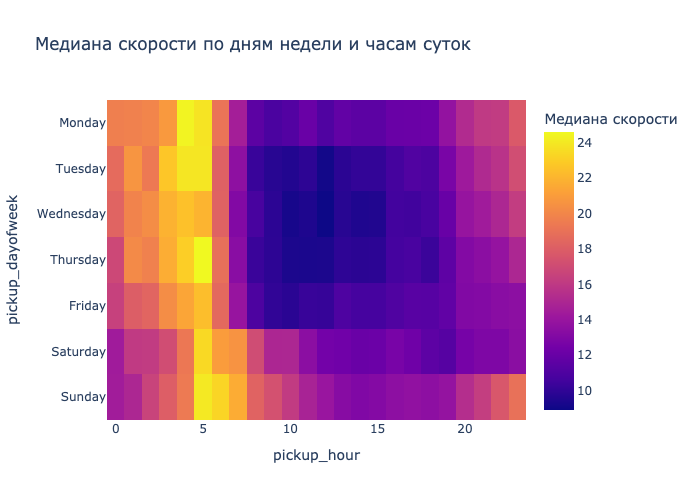

In [83]:
df_train_1['avg speed (km/h)'] = np.expm1(df_train_1['log_haversine']) / (np.expm1(df_train_1['log_trip_duration']) / 60**2)

median_speed_df = df_train_1.groupby(['pickup_dayofweek', 'pickup_hour'])['avg speed (km/h)'].median().reset_index()

median_speed_df['mas'] = median_speed_df['avg speed (km/h)']

median_speed_df['pickup_dayofweek'] = pd.Categorical(median_speed_df['pickup_dayofweek'], categories=ordered_days, ordered=True)

heatmap_df = median_speed_df.pivot(index='pickup_dayofweek', columns='pickup_hour', values='mas')

fig = px.imshow(
    heatmap_df,
    x=heatmap_df.columns,
    y=heatmap_df.index,
    labels=dict(color='Медиана скорости'),
    title='Медиана скорости по дням недели и часам суток'
)

fig.show(renderer='png')


In [84]:
# удалим наш индекс пробок из списка фичей и добавим среднюю скорость по дням и по часам

df_train_2 = df_train_2.merge(median_speed_df[['pickup_dayofweek', 'pickup_hour', 'mas']],
                              on=['pickup_dayofweek', 'pickup_hour'],
                              how='left')

df_train_2

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,pickup_dayofyear,haversine_distance,log_haversine,road_condition,p_jfk,d_jfk,p_laguarda,d_laguarda,log_skewed_manhattan,mas
0,id2319257,1,2016-06-11 13:35:16,1,-73.961479,40.771442,-73.966034,40.765182,0,5.093750,...,163,0.794761,0.584872,3,False,False,False,False,0.623861,12.323319
1,id3828976,1,2016-03-14 18:21:54,1,-73.952377,40.783741,-73.954926,40.780289,0,4.532599,...,74,0.439767,0.364481,3,False,False,False,False,0.390274,12.144642
2,id3388067,0,2016-03-25 13:29:36,1,-73.988480,40.774143,-73.980499,40.782967,0,5.533389,...,85,1.189165,0.783520,3,False,False,False,False,0.894390,10.990766
3,id3583239,1,2016-01-17 23:18:44,1,-73.993431,40.742043,-73.990303,40.759888,0,5.541264,...,17,2.001709,1.099182,2,False,False,False,False,1.304071,18.964226
4,id0935234,0,2016-01-03 01:51:16,1,-74.008064,40.738224,-73.976242,40.744186,0,6.861711,...,3,2.761733,1.324880,2,False,False,False,False,1.798725,14.992269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645267,id1091307,1,2016-01-26 15:47:30,1,-73.983299,40.749664,-73.977272,40.761623,0,7.510431,...,26,1.423401,0.885172,3,False,False,False,False,0.998076,10.077256
645268,id2342132,1,2016-06-09 16:59:50,1,-73.948601,40.782150,-73.957260,40.770130,0,6.171701,...,161,1.522531,0.925263,3,False,False,False,False,0.980200,10.621076
645269,id1998162,1,2016-01-05 15:15:53,2,-73.987610,40.750256,-73.973389,40.761082,0,6.637258,...,5,1.698237,0.992599,3,False,False,False,False,1.239910,10.077256
645270,id0942028,1,2016-03-12 16:53:22,2,-73.980301,40.738869,-73.986870,40.750912,0,6.729824,...,72,1.448960,0.895663,3,False,False,False,False,1.098966,12.656366


In [85]:
df_test = df_test.merge(median_speed_df[['pickup_dayofweek', 'pickup_hour', 'mas']],
                              on=['pickup_dayofweek', 'pickup_hour'],
                              how='left')

df_val = df_val.merge(median_speed_df[['pickup_dayofweek', 'pickup_hour', 'mas']],
                              on=['pickup_dayofweek', 'pickup_hour'],
                              how='left')

In [86]:
CATEGORICAL_FEATS = [
    'pickup_dayofweek',
    'pickup_month',
    'anomaly_flg',
    'p_jfk',
    'd_jfk',
    'p_laguarda',
    'd_laguarda',
    'mas',
    'pickup_dayofyear',
    'pickup_hour'
]

NUMERIC_FEATS = [
    'log_skewed_manhattan'
]

fit_predict(df_train_2, df_val, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge(alpha=best_alpha))

0.37001976210453164

In [87]:
# ну все, по идее этого должно хватить для макс балла за задание

final_test_rmse = fit_predict(df_train_2, df_test, NUMERIC_FEATS, CATEGORICAL_FEATS, Ridge(alpha=best_alpha))

print(f'baseline:  {best_rmse:.4f}    my_best  {final_test_rmse:.4f}    diff:  {best_rmse - final_test_rmse:.4f}')

# ГОООООООЛ


baseline:  0.4699    my_best  0.4429    diff:  0.0270


Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

![](https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcTfs0DEjY4vZaRrOJ8yPxyid7ThLSO-G0FRFVJPEf7G5Bl0hzey)

# КОНЕЦ ОЦЕНИВАЕМОЙ ЧАСТИ, ДАЛЬШЕ Я ИГРАЮСЬ

Перебор гиперпараметров - это наше все

In [89]:
# во избежание переобучения будем семплить df_train_ и df_val_ каждый раз из df_train_2 + df_val

df_for_optuna = pd.concat([df_train_2, df_val], ignore_index=True)

In [91]:
import optuna

def objective(trial):
    
    CATEGORICAL_FEATS = [
        'pickup_dayofweek',
        'pickup_month',
        'anomaly_flg',
        'p_jfk',
        'd_jfk',
        'p_laguarda',
        'd_laguarda',
        'mas',
        'pickup_dayofyear',
        'pickup_hour'
    ]

    NUMERIC_FEATS = [
        'log_skewed_manhattan'
    ]
    
    # во избежание переобучения будем семплить df_train_ и df_val_ каждый раз из df_train_2 + df_val
    
    df_train_, df_val_ = train_test_split(df_for_optuna, test_size=0.25)
    
    n_rows = trial.suggest_int('n_rows', 50, 200)
    n_cols = trial.suggest_int('n_cols', 50, 200)
    quantile = trial.suggest_categorical('quantile', [0.95, 0.99, 0.995, 0.999])
    feature_threshold = trial.suggest_int('feature_threshold', 50, 200)
    nlargest_routs = trial.suggest_int('nlargest_routs', 100, 400)
    
    model = Ridge(best_alpha)
    
    rmse = fit_predict(
        df_train_,
        df_val_, 
        NUMERIC_FEATS,
        CATEGORICAL_FEATS,
        model,
        n_rows, 
        n_cols, 
        quantile, 
        feature_threshold,
        nlargest_routs,
    )
    
    return rmse

study = optuna.create_study(direction="minimize")

study.optimize(lambda trial: objective(trial), n_trials=128, n_jobs=6)
    
best_trial = study.best_trial

best_trial.params

[I 2024-10-28 15:20:11,210] A new study created in memory with name: no-name-b72334e7-7052-4090-9ddd-f2a972ddc1b1
[I 2024-10-28 15:20:37,120] Trial 2 finished with value: 0.37026600007164184 and parameters: {'n_rows': 66, 'n_cols': 71, 'quantile': 0.995, 'feature_threshold': 73, 'nlargest_routs': 153}. Best is trial 2 with value: 0.37026600007164184.
[I 2024-10-28 15:20:45,047] Trial 5 finished with value: 0.3714181201871484 and parameters: {'n_rows': 103, 'n_cols': 154, 'quantile': 0.999, 'feature_threshold': 150, 'nlargest_routs': 270}. Best is trial 2 with value: 0.37026600007164184.
[I 2024-10-28 15:20:51,392] Trial 4 finished with value: 0.3718946556161814 and parameters: {'n_rows': 83, 'n_cols': 146, 'quantile': 0.995, 'feature_threshold': 184, 'nlargest_routs': 333}. Best is trial 2 with value: 0.37026600007164184.
[I 2024-10-28 15:20:56,051] Trial 6 finished with value: 0.37247692728380627 and parameters: {'n_rows': 178, 'n_cols': 51, 'quantile': 0.999, 'feature_threshold': 162

[I 2024-10-28 15:24:27,522] Trial 34 finished with value: 0.3686826594732037 and parameters: {'n_rows': 126, 'n_cols': 138, 'quantile': 0.99, 'feature_threshold': 65, 'nlargest_routs': 240}. Best is trial 32 with value: 0.36813401868210816.
[I 2024-10-28 15:24:35,264] Trial 35 finished with value: 0.3686432417937686 and parameters: {'n_rows': 184, 'n_cols': 135, 'quantile': 0.99, 'feature_threshold': 95, 'nlargest_routs': 240}. Best is trial 32 with value: 0.36813401868210816.
[I 2024-10-28 15:24:38,993] Trial 37 finished with value: 0.367792005484767 and parameters: {'n_rows': 185, 'n_cols': 102, 'quantile': 0.99, 'feature_threshold': 69, 'nlargest_routs': 375}. Best is trial 37 with value: 0.367792005484767.
[I 2024-10-28 15:24:44,668] Trial 38 finished with value: 0.36819109292986757 and parameters: {'n_rows': 183, 'n_cols': 102, 'quantile': 0.99, 'feature_threshold': 69, 'nlargest_routs': 390}. Best is trial 37 with value: 0.367792005484767.
[I 2024-10-28 15:24:48,238] Trial 36 fin

[I 2024-10-28 15:27:38,731] Trial 68 finished with value: 0.36918836970915475 and parameters: {'n_rows': 111, 'n_cols': 147, 'quantile': 0.99, 'feature_threshold': 67, 'nlargest_routs': 260}. Best is trial 52 with value: 0.3673304680519507.
[I 2024-10-28 15:27:46,365] Trial 71 finished with value: 0.368339933401107 and parameters: {'n_rows': 111, 'n_cols': 93, 'quantile': 0.95, 'feature_threshold': 56, 'nlargest_routs': 353}. Best is trial 52 with value: 0.3673304680519507.
[I 2024-10-28 15:27:50,631] Trial 70 finished with value: 0.3718360301121036 and parameters: {'n_rows': 108, 'n_cols': 151, 'quantile': 0.95, 'feature_threshold': 57, 'nlargest_routs': 386}. Best is trial 52 with value: 0.3673304680519507.
[I 2024-10-28 15:27:58,832] Trial 72 finished with value: 0.3684273650204614 and parameters: {'n_rows': 119, 'n_cols': 128, 'quantile': 0.95, 'feature_threshold': 56, 'nlargest_routs': 320}. Best is trial 52 with value: 0.3673304680519507.
[I 2024-10-28 15:28:10,191] Trial 74 fini

[I 2024-10-28 15:31:08,526] Trial 104 finished with value: 0.3685679103649799 and parameters: {'n_rows': 71, 'n_cols': 189, 'quantile': 0.99, 'feature_threshold': 66, 'nlargest_routs': 370}. Best is trial 52 with value: 0.3673304680519507.
[I 2024-10-28 15:31:14,621] Trial 107 finished with value: 0.37049783949550597 and parameters: {'n_rows': 93, 'n_cols': 117, 'quantile': 0.99, 'feature_threshold': 66, 'nlargest_routs': 334}. Best is trial 52 with value: 0.3673304680519507.
[I 2024-10-28 15:31:21,050] Trial 106 finished with value: 0.3698728276507605 and parameters: {'n_rows': 94, 'n_cols': 179, 'quantile': 0.99, 'feature_threshold': 65, 'nlargest_routs': 127}. Best is trial 52 with value: 0.3673304680519507.
[I 2024-10-28 15:31:24,921] Trial 105 finished with value: 0.37214611350788945 and parameters: {'n_rows': 125, 'n_cols': 188, 'quantile': 0.99, 'feature_threshold': 65, 'nlargest_routs': 372}. Best is trial 52 with value: 0.3673304680519507.
[I 2024-10-28 15:31:28,547] Trial 108

{'n_rows': 95,
 'n_cols': 92,
 'quantile': 0.99,
 'feature_threshold': 61,
 'nlargest_routs': 342}

In [92]:
final_test_rmse_2 = fit_predict(
    df_train_2,
    df_test, 
    NUMERIC_FEATS,
    CATEGORICAL_FEATS,
    Ridge(best_alpha),
    best_trial.params['n_rows'], 
    best_trial.params['n_cols'], 
    best_trial.params['quantile'],
    best_trial.params['feature_threshold'],
    best_trial.params['nlargest_routs'],
)

print(f'baseline:  {best_rmse:.4f}    my_best  {final_test_rmse_2:.4f}    diff:  {best_rmse - final_test_rmse_2:.4f}')


baseline:  0.4699    my_best  0.4429    diff:  0.0270


Оптуна нам ничего не дала...